# HSPC subpopulation analysis
## Xiaonan Wang
## 23May2023

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
from os import listdir
from os.path import isfile, join
import re
import anndata
import seaborn as sns

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.20.3 scipy==1.7.3 pandas==1.3.5 scikit-learn==1.0.1 statsmodels==0.13.1 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


In [6]:
adata = sc.read('./write/raw_afterQC_all_lognorm_processed_regressout_cellcycle.h5ad')

In [7]:
sc.tl.leiden(adata, resolution=0.5, key_added="Leiden_v2")

running Leiden clustering
    finished: found 16 clusters and added
    'Leiden_v2', the cluster labels (adata.obs, categorical) (0:00:04)


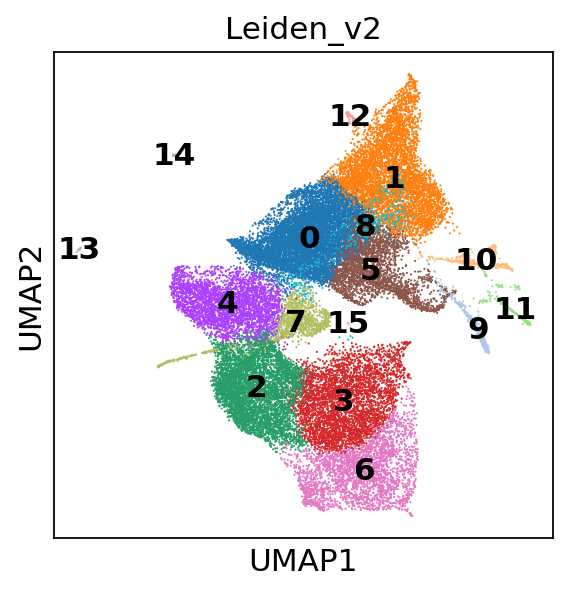

In [37]:
sc.pl.umap(adata, color='Leiden_v2', legend_loc='on data')

In [27]:
print(adata.obs_keys())

['batch', 'sample', 'doublet_score', 'n_genes', 'percent_mito', 'n_counts', 'cluster', 'Genotype', 'Condition', 'phase', 'S_score', 'G2M_score', 'Dahlin_CT', 'Nestorowa_CT', 'Combined_CT', 'Leiden_v1']


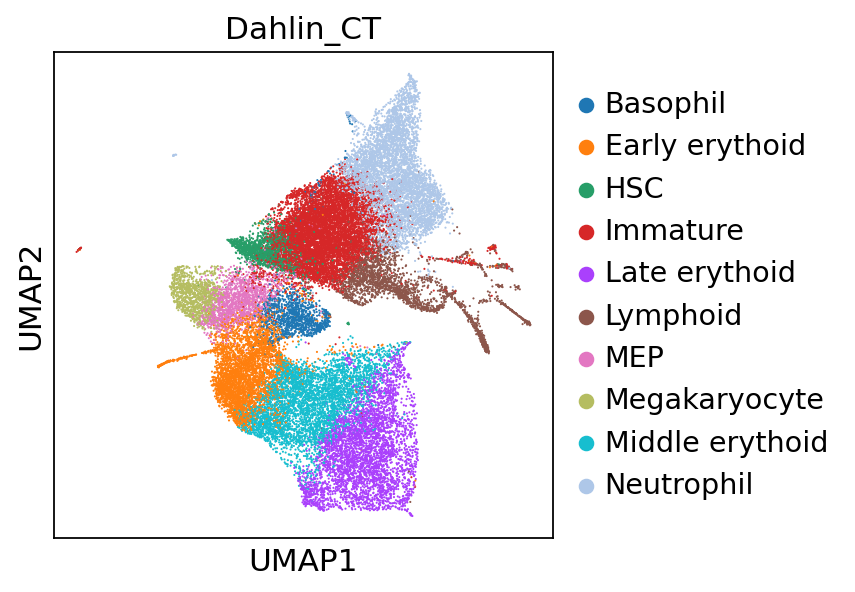

In [3]:
sc.pl.umap(adata, color='Dahlin_CT')

In [8]:
adata = adata[np.in1d(adata.obs['Dahlin_CT'], ['HSC', 'Immature'])].copy()

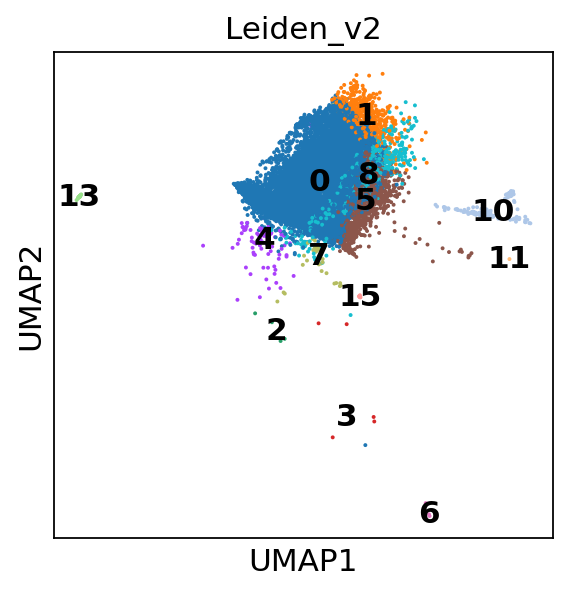

In [64]:
sc.pl.umap(adata, color='Leiden_v2', legend_loc='on data')

In [9]:
adata = adata[np.in1d(adata.obs['Leiden_v2'], ['0', '1', '5'])].copy()

In [10]:
sc.pp.regress_out(adata, keys=['n_counts', 'percent_mito'])
sc.pp.scale(adata)
sc.pp.regress_out(adata, keys=['G2M_score', 'S_score'])
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

regressing out ['n_counts', 'percent_mito']
    finished (0:00:13)
regressing out ['G2M_score', 'S_score']
    finished (0:00:08)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


In [17]:
adata.obs['Nestorowa_CT'] = adata.obs['Nestorowa_CT'].cat.reorder_categories(['LTHSC', 'STHSC', 'MPP1', 'MPP2', 'MPP3','LMPP', 'GMP'])

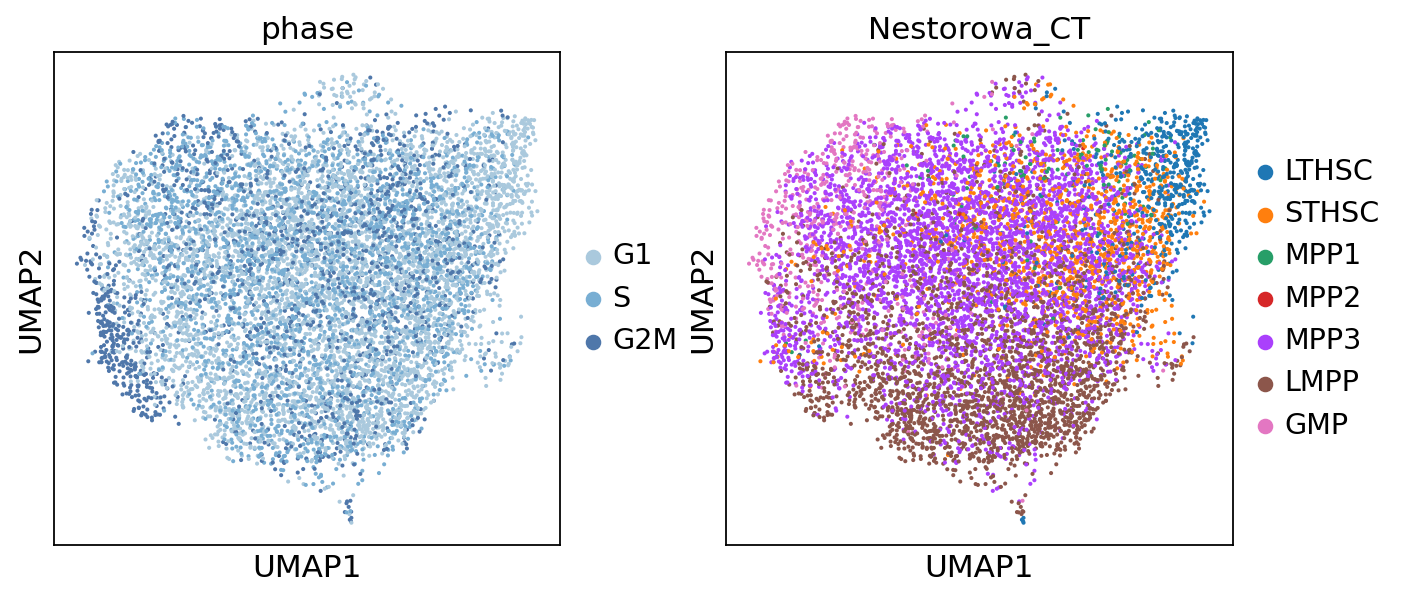

In [18]:
sc.pl.umap(adata, color=['phase','Nestorowa_CT'])

WT
Aldh2KO
Adh5KO
DKO


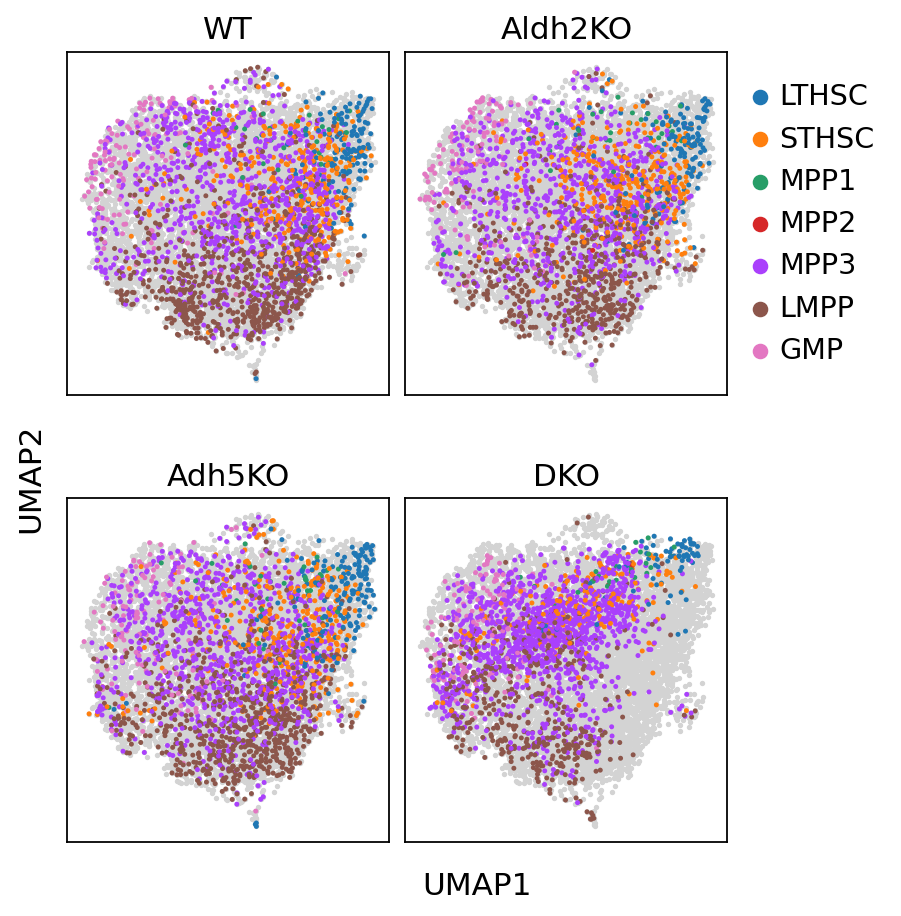

In [3]:
# split in condition
fig, ax=plt.subplots(2,3, figsize=(8,6.5), squeeze=False)
cat = adata.obs['Condition'].cat.categories
for i in range(len(cat)):
    colidx = i%2
    rowidx = np.floor(i/2).astype(int)
    print(cat[i])
    ax[rowidx][colidx].scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1],s=2, c='#d3d3d3')

    if i == 1:
        legend_loc = 'right margin'
    else:
        legend_loc = ''
        
    sc.pl.umap(adata[adata.obs['Condition'] == cat[i]],s=20, color='Nestorowa_CT', title=cat[i], ax=ax[rowidx][colidx], show=False, legend_loc=legend_loc)
    ax[rowidx][colidx].set_xlabel('')
    ax[rowidx][colidx].set_ylabel('')

for i in [2,5]:
    fig.delaxes(ax.flatten()[i])
    
fig.text(0.5, 0.1, 'UMAP1', ha='center')
fig.text(0.14, 0.5, 'UMAP2', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.05, hspace=0.3)
plt.savefig('Umap_Genotype_split.pdf', bbox_inches='tight')

In [9]:
adata.write('./write/HSC_Immature.h5ad')

In [3]:
adata = sc.read('./write/HSC_Immature.h5ad')

In [5]:
sc.tl.leiden(adata, resolution = 0.5, key_added='Leiden_v3')

running Leiden clustering
    finished: found 6 clusters and added
    'Leiden_v3', the cluster labels (adata.obs, categorical) (0:00:00)


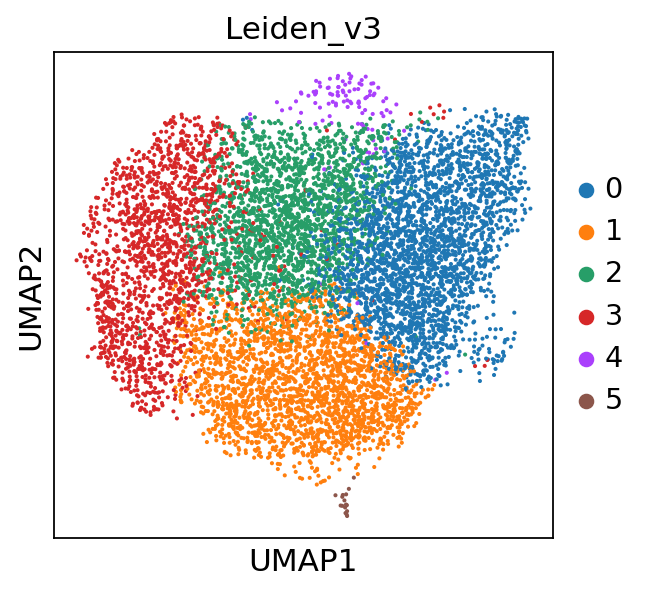

In [6]:
sc.pl.umap(adata, color='Leiden_v3')

WT
Aldh2KO
Adh5KO
DKO


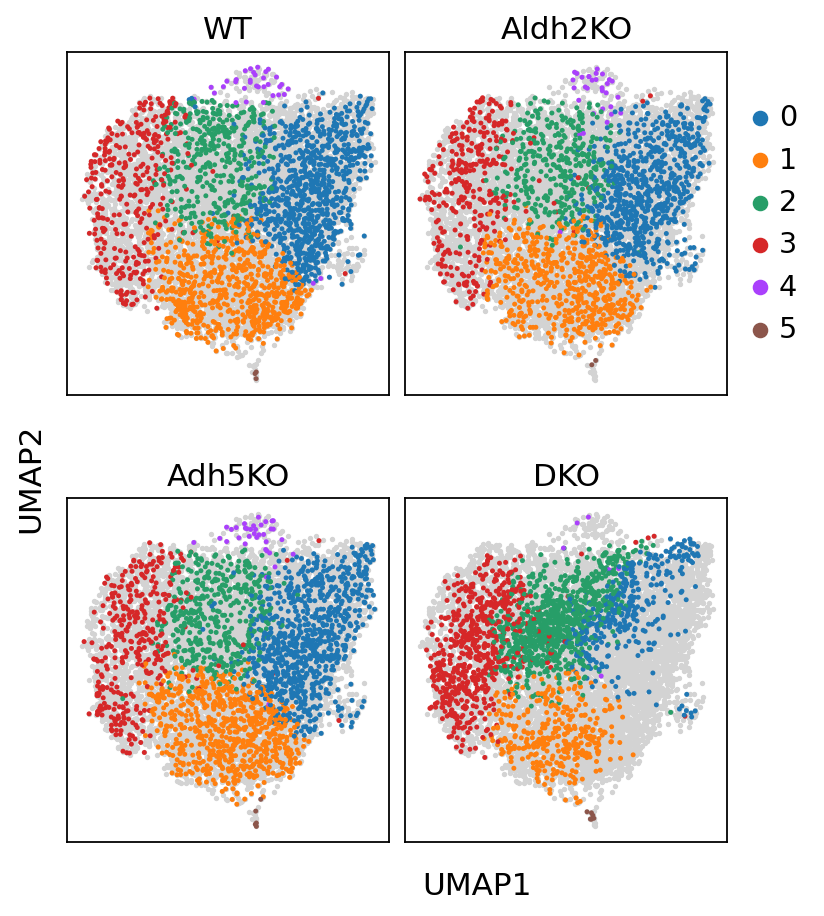

In [7]:
# Figure3D
# split in condition
fig, ax=plt.subplots(2,3, figsize=(8,6.5), squeeze=False)
cat = adata.obs['Condition'].cat.categories
for i in range(len(cat)):
    colidx = i%2
    rowidx = np.floor(i/2).astype(int)
    print(cat[i])
    ax[rowidx][colidx].scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1],s=2, c='#d3d3d3')

    if i == 1:
        legend_loc = 'right margin'
    else:
        legend_loc = ''
        
    sc.pl.umap(adata[adata.obs['Condition'] == cat[i]],s=20, color='Leiden_v3', title=cat[i], ax=ax[rowidx][colidx], show=False, legend_loc=legend_loc)
    ax[rowidx][colidx].set_xlabel('')
    ax[rowidx][colidx].set_ylabel('')

for i in [2,5]:
    fig.delaxes(ax.flatten()[i])
    
fig.text(0.5, 0.1, 'UMAP1', ha='center')
fig.text(0.14, 0.5, 'UMAP2', va='center', rotation='vertical')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [8]:
tab1 = pd.crosstab(adata.obs['Condition'], adata.obs['Leiden_v3'])
tab1

Leiden_v3    0    1    2    3   4  5
Condition                           
WT         881  664  408  327  34  3
Aldh2KO    757  581  359  312  31  2
Adh5KO     835  691  422  343  36  5
DKO        348  344  863  588   7  6

In [42]:
tab1.to_csv('Table_Condition_Leiden_v3.csv')

In [10]:
genelist = {
    'HSC': ['Procr', 'Mllt3', 'Mettl7a1'],
    'Lym': ['Flt3', 'Dntt'],
    'Mye': ['Mpo', 'Ctsg', 'Cdk6']
}

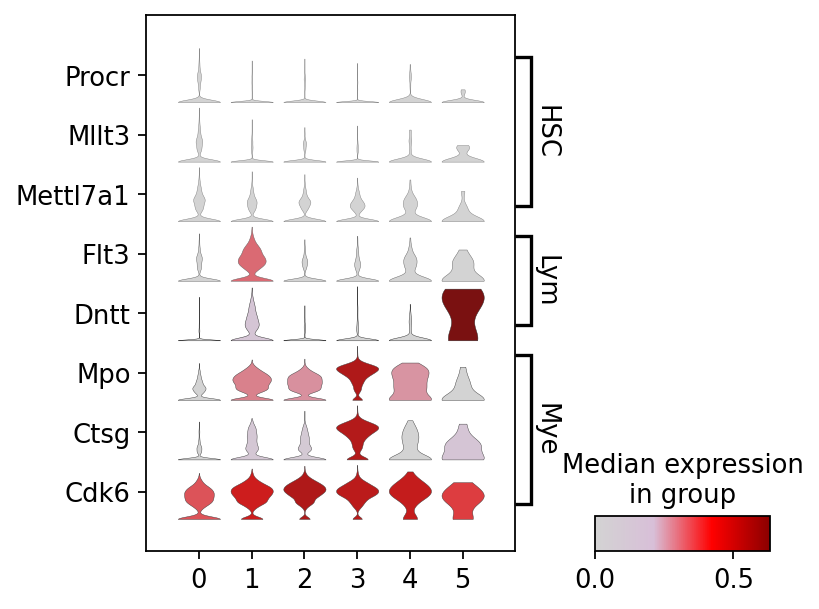

In [15]:
sc.pl.stacked_violin(adata, groupby='Leiden_v3', var_names=genelist, cmap=cmap, swap_axes=True, standard_scale='var', figsize=(5,4))

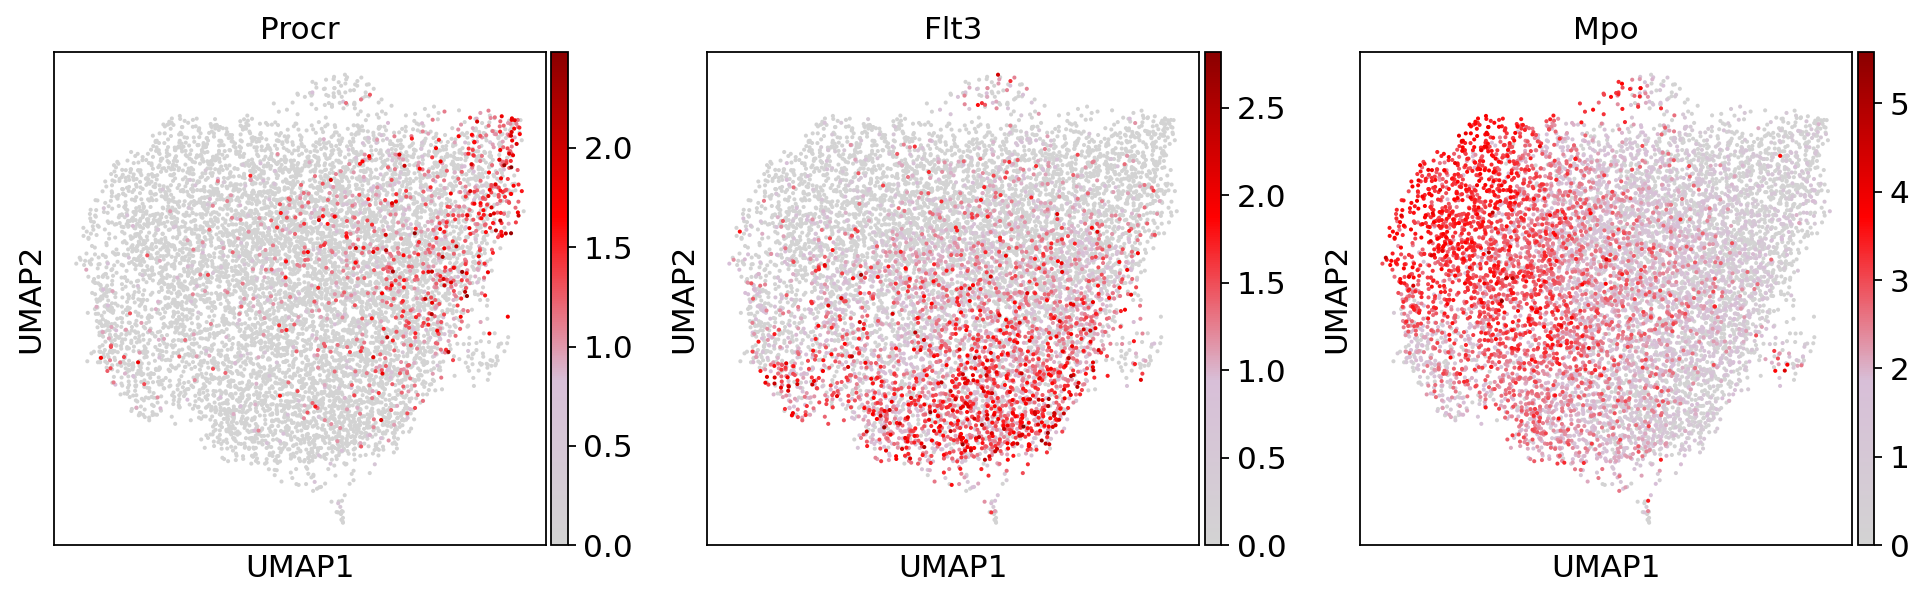

In [16]:
sc.pl.umap(adata, color=['Procr', 'Flt3', 'Mpo'], color_map=cmap)

In [11]:
tab2 = pd.crosstab(adata.obs['Condition'], adata.obs['Leiden_v3'], normalize=0)*100
tab2

Leiden_v3          0          1          2          3         4         5
Condition                                                                
WT         38.023306  28.657747  17.608977  14.113077  1.467415  0.129478
Aldh2KO    37.071499  28.452498  17.580803  15.279138  1.518119  0.097943
Adh5KO     35.806175  29.631218  18.096055  14.708405  1.543739  0.214408
DKO        16.141002  15.955473  40.027829  27.272727  0.324675  0.278293

In [12]:
tab2.to_csv('HSPC_Freq_Aldh2Adh5_leiden_v3.csv')

In [15]:
ctdef = {
    '0':'HSCs',
    '1':'LMPP-1',
    '2':'Myeloid',
    '3':'Myeloid/GMP',
    '4':'Mixed',
    '5':'LMPP-2'
}

In [42]:
adata.obs['CT'] = [ctdef[x] for x in adata.obs['Leiden_v3']]
adata.obs['CT'] = adata.obs['CT'].astype('category')

In [44]:
adata.obs['CT'] = adata.obs['CT'].cat.reorder_categories(['HSCs', 'Myeloid', 'Myeloid/GMP', 'LMPP-1', 'LMPP-2', 'Mixed'])

In [45]:
adata.obs['CT'].cat.categories

Index(['HSCs', 'Myeloid', 'Myeloid/GMP', 'LMPP-1', 'LMPP-2', 'Mixed'], dtype='object')

In [46]:
adata.uns['CT_colors'] = np.array(adata.uns['Leiden_v3_colors'])[[0,2,3,1,5,4]]

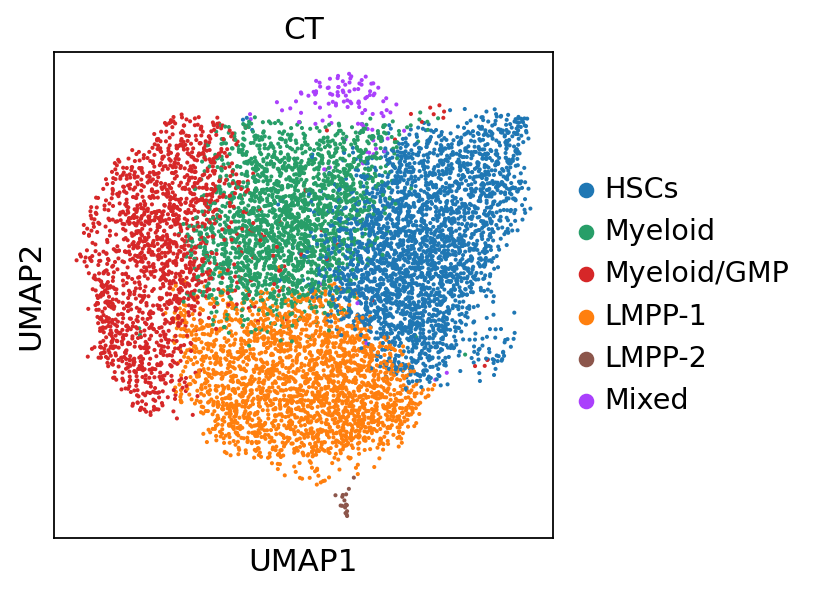

In [47]:
sc.pl.umap(adata, color='CT')

In [48]:
tab = pd.crosstab(adata.obs.Condition, adata.obs.CT, normalize=0)*100

Text(0.5, 0, '')

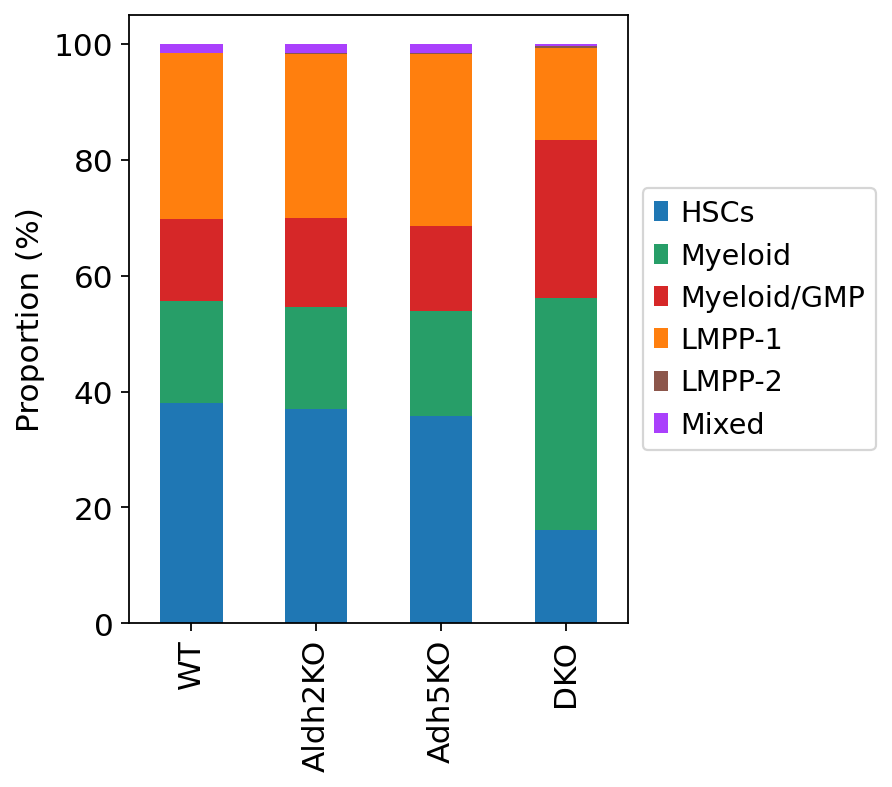

In [52]:
# Figure3D
fig, ax = plt.subplots(figsize=(4,5))
tab.plot.bar(stacked=True, ax=ax, color=adata.uns['CT_colors'])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(False)
ax.set_ylabel('Proportion (%)')
ax.set_xlabel('')

In [53]:
adata.write('./write/HSC_Immature.h5ad')

# p53score

In [54]:
adata = sc.read('./write/HSC_Immature.h5ad')

In [57]:
p53GL = np.genfromtxt('/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Niki/Patel_SMQ2/Analysis_17Feb2021/p53GL.txt', dtype='str')

In [58]:
print(p53GL)

['Aen' 'Bax' 'Bbc3' 'Casp1' 'Ccng1' 'Cdkn1a' 'Ctsd' 'Eda2r' 'Ier5' 'Perp'
 'Phlda3' 'Pml' 'Pvt1' 'Sulf2' 'Tnfrsf10b' 'Zmat3']


In [59]:
adata_norm = anndata.AnnData(X=adata.raw.X, var=adata.raw.var, obs=adata.obs, obsm=adata.obsm)

In [60]:
sc.pp.scale(adata_norm)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [61]:
sc.tl.score_genes(adata_norm, p53GL)

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    400 total control genes are used. (0:00:00)


In [62]:
adata.obs['p53score'] = adata_norm.obs['score']

In [63]:
adata.write('./write/HSC_Immature.h5ad')

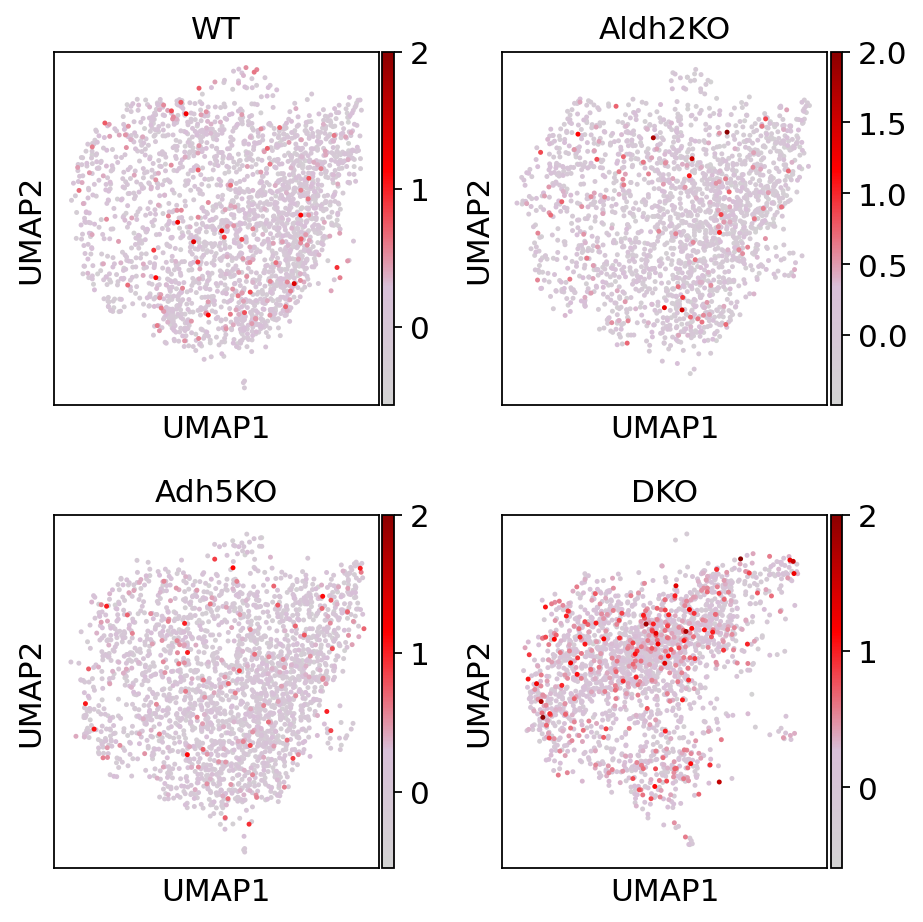

In [35]:
# FigureS5C
fig, ax = plt.subplots(2,2, figsize=(6,6), sharex=True, sharey=True)
ax = ax.flatten()
cat = adata.obs['Condition'].cat.categories
for i in range(len(cat)):
    sc.pl.umap(adata[adata.obs['Condition'] == cat[i]], color='p53score', color_map=cmap, show=False, s=20, ax=ax[i], title=cat[i], vmax=2)
plt.tight_layout()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Adh5KO v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.999e-38 U_stat=1.949e+06
Aldh2KO v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.830e-31 U_stat=1.740e+06
WT v.s. DKO: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.518e-33 U_stat=1.979e+06


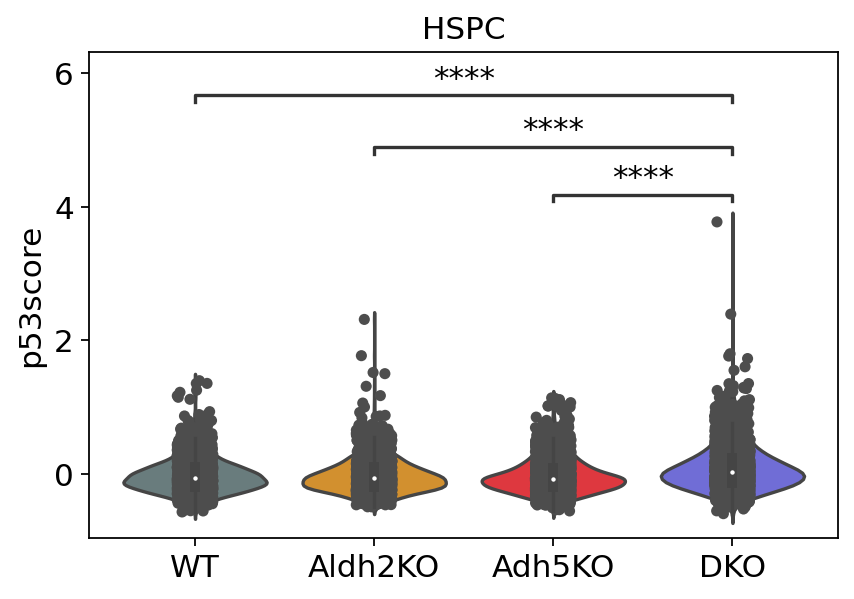

In [22]:
# FigureS5C
from statannot import add_stat_annotation
import seaborn as sns
fig, ax = plt.subplots(figsize=(6,4))
df = adata.obs[['p53score', 'Condition']]
sns.violinplot(x='Condition', y='p53score', data=df,  scale='width', ax=ax, palette=['#657F81', '#ED9514', '#FA1C26', '#605BE8'])
sns.stripplot(x="Condition", y="p53score", data=df, jitter=True, zorder=1, color=".3")
ax.grid(False)
ax.set_xlabel('')
ax.set_title('HSPC')
add_stat_annotation(ax, data=df, x='Condition', y='p53score',
                        box_pairs=[('WT', 'DKO'),('Aldh2KO', 'DKO'), ("Adh5KO", "DKO")],
                        test='Mann-Whitney', text_format='star', loc='inside', verbose=2)